In [1]:
#Import librerie
import os
from pathlib import Path
import numpy as np
from PIL import Image
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.segmentation import fcn_resnet50

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as TF
import torch
import torch.nn.functional as F

In [2]:
#Configurazioni
base_path = "/kaggle/input/coco-2017-dataset/coco2017"
train_img_dir = os.path.join(base_path, "train2017")
train_ann_file = os.path.join(base_path, "annotations/instances_train2017.json")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters
IMG_SIZE = (1024, 1024)
BATCH_SIZE = 2
NUM_WORKERS = 4
LR = 4.4e-4
NUM_EPOCHS = 10

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [3]:
##############################################################
#    LOSS FUNCTIONS RICHIESTE DAL PROGETTO (G4)  
#    CrossEntropy, Dice, Jaccard(IoU), Focal 
#   + combinazioni 
##############################################################

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = F.softmax(logits, dim=1) 
        targets_onehot = F.one_hot(targets, num_classes).permute(0,3,1,2).float()
        dims = (0,2,3)
        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot, dims)
        dice = (2*intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = F.softmax(logits, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0,3,1,2).float()
        dims = (0,2,3)
        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot - probs * targets_onehot, dims)
        iou = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        pt = torch.exp(-ce)
        focal = self.alpha * (1-pt)**self.gamma * ce
        return focal.mean()


ce_loss = nn.CrossEntropyLoss() #CrossEntropyLoss
dice_loss = DiceLoss()         #DiceLoss
iou_loss = IoULoss()          #Jaccard/IoU Loss
focal_loss = FocalLoss(gamma=2.0, alpha=0.25)  #FocalLoss

#Combinazioni Loss

#CrossEntropy+Dice Loss
def loss_ce_dice(logits, targets):      
    return ce_loss(logits, targets) + dice_loss(logits, targets)

#CrossEntropy+IoU
def loss_ce_iou(logits, targets):
    return ce_loss(logits, targets) + iou_loss(logits, targets)

#Focal+Dice
def loss_focal_dice(logits, targets):
    return focal_loss(logits, targets) + dice_loss(logits, targets)

In [4]:
#Scelta Loss
def compute_loss(logits, targets):

    if LOSS_MODE == "CE":
        return ce_loss(logits, targets)

    elif LOSS_MODE == "DICE":
        return dice_loss(logits, targets)

    elif LOSS_MODE == "IOU":
        return iou_loss(logits, targets)

    elif LOSS_MODE == "FOCAL":
        return focal_loss(logits, targets)

    elif LOSS_MODE == "CE+DICE":
        return loss_ce_dice(logits, targets)

    elif LOSS_MODE == "CE+IOU":
        return loss_ce_iou(logits, targets)

    elif LOSS_MODE == "FOCAL+DICE":
        return loss_focal_dice(logits, targets)

    else:
        raise ValueError(f"Loss non riconosciuta: {LOSS_MODE}")


LOSS_MODE = "CE"
LOSS_NAMES = {
    "CE": "CrossEntropy Loss",
    "DICE": "Dice Loss",
    "IOU": "IoU / Jaccard Loss",
    "FOCAL": "Focal Loss",
    "CE+DICE": "CrossEntropy + Dice Loss",
    "CE+IOU": "CrossEntropy + IoU Loss",
    "FOCAL+DICE": "Focal + Dice Loss"
}
print(f"Loss selezionata: {LOSS_NAMES.get(LOSS_MODE, 'Unknown Loss')}")

Loss selezionata: CrossEntropy Loss


In [5]:
coco = COCO(train_ann_file)
cat_ids = sorted(coco.getCatIds()) 
cat2label = {cat_id: idx+1 for idx, cat_id in enumerate(cat_ids)}

NUM_CLASSES = len(cat_ids) + 1 
print("NUM_CLASSES (including background):", NUM_CLASSES)


loading annotations into memory...
Done (t=20.35s)
creating index...
index created!
NUM_CLASSES (including background): 81


In [6]:
#DatasetCustom
class COCOSegmentationDataset(Dataset):
    def __init__(self, img_dir, coco, cat2label, target_size=(1024,1024)):
        self.img_dir = img_dir
        self.coco = coco
        self.ids = coco.getImgIds()
        self.cat2label = cat2label
        self.target_size = target_size

    def _build_mask(self, anns, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = sorted(anns, key=lambda a: a["area"], reverse=True)
        for ann in anns:
            m = self.coco.annToMask(ann)
            label = self.cat2label[ann["category_id"]]
            mask[m > 0] = label
        return mask

    def _resize_(self, img, target_size, resample):
        tw, th = target_size
        h, w = img.size
        scale = min(tw / w, th / h)
        nw, nh = int(w * scale), int(h * scale)
        img = img.resize((nw, nh), resample)
        canvas = Image.new(img.mode, (tw, th), 0)
        canvas.paste(img, ((tw - nw)//2, (th - nh)//2))
        return canvas

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        img = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = Image.fromarray(self._build_mask(anns, info["height"], info["width"]))

        # Resize 
        img = self._resize_(img, self.target_size, Image.BILINEAR)
        mask = self._resize_(mask, self.target_size, Image.NEAREST)

        img = TF.to_tensor(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return img, mask

    def __len__(self):
        return len(self.ids)


In [7]:
full_dataset = COCOSegmentationDataset(train_img_dir, coco, cat2label, target_size=IMG_SIZE)
small_subset = torch.utils.data.Subset(full_dataset, list(range(min(10000, len(full_dataset)))))
num_samples = len(small_subset)
num_train = int(num_samples*0.8)
num_val = num_samples - num_train
train_set, val_set = torch.utils.data.random_split(small_subset, [num_train, num_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Train:", len(train_set))
print("Val:", len(val_set))

Train: 8000
Val: 2000


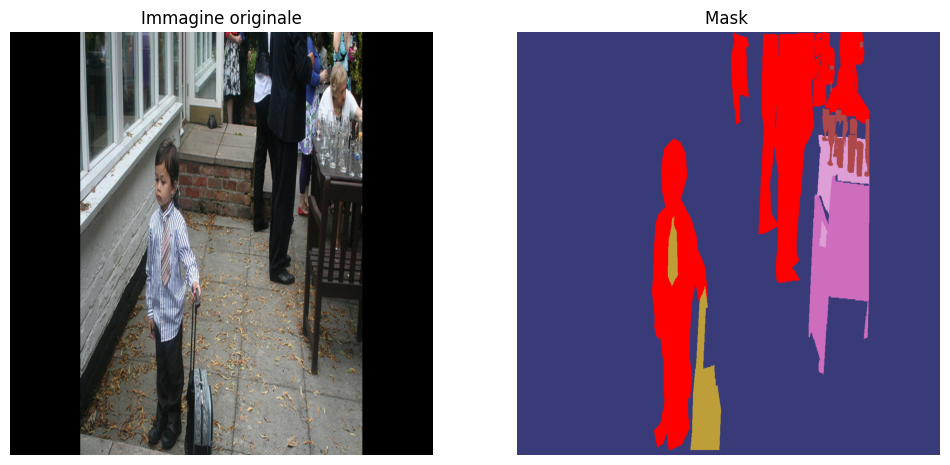

In [8]:
def show_gt_sample(dataset, idx):
    img, mask = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()

    num_classes = mask.max().item() + 1 

    # Colormap 
    cmap = plt.get_cmap("tab20b", num_classes) 
    mask_color = cmap(np.arange(num_classes) / (num_classes - 1))[:, :3] 
    mask_color = (mask_color * 255).astype(np.uint8)
    mask_color[1] = np.array([255, 0, 0], dtype=np.uint8) #Color-mask rossa per persone 
    mask_rgb = mask_color[mask.numpy()]

    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_rgb)
    plt.title("Mask ")
    plt.axis("off")

    plt.show()


show_gt_sample(small_subset, random.randint(0, len(small_subset)-1))

In [9]:
# Model: FCN-ResNet50 from scratch
model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)

# Otimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


In [10]:
# 10 learning rate  tra 1e-3 e 1e-5

#lr_values = np.logspace(-2, -5, 10)
#print("Learning rates:", lr_values)
#results_train_loss = []
#results_val_loss = []

#for lr in lr_values:
    #print(f"  Addestramento completo con LR = {lr:.6e}")
    #model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    #best_train_loss = None
    #best_val_loss = None

    #for epoch in range(1, NUM_EPOCHS + 1):
        # TRAIN 

        #model.train()
        #running_train_loss = 0.0
        #pbar = tqdm(train_loader, desc=f"LR={lr:.1e} | Epoch {epoch}/{NUM_EPOCHS}")
        #for i, (imgs, masks) in enumerate(pbar, 1):
            #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            #optimizer.zero_grad()
            #outputs = model(imgs)["out"]
            #loss = criterion(outputs, masks)
            #loss.backward()
            #optimizer.step()

            #running_train_loss += loss.item()
            #avg_train_loss = running_train_loss / i
            #pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}")

        #VALIDATION 

        #model.eval()
        #running_val_loss = 0.0
        #with torch.no_grad():
            #for imgs, masks in val_loader:
                #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                #outputs = model(imgs)["out"]
                #loss = criterion(outputs, masks)
                #running_val_loss += loss.item()

        #avg_val_loss = running_val_loss / len(val_loader)

        #print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        # Salvataggio miglior loss lungo le epoche
        #if best_train_loss is None or avg_train_loss < best_train_loss:
         #   best_train_loss = avg_train_loss
        #if best_val_loss is None or avg_val_loss < best_val_loss:
         #   best_val_loss = avg_val_loss

    
    #results_train_loss.append(best_train_loss)
    #results_val_loss.append(best_val_loss)

    #print(f"--> LR={lr:.1e} | best_train_loss={best_train_loss:.4f}, best_val_loss={best_val_loss:.4f}")

    # libero memoria GPU prima di passare al prossimo LR
    #del model, optimizer
    #torch.cuda.empty_cache()

In [11]:
#plt.figure(figsize=(8,5))

#plt.semilogx(lr_values, results_val_loss, marker="o", label="Best Validation Loss")
#plt.semilogx(lr_values, results_train_loss, marker="x", linestyle="--", label="Best Train Loss")

#plt.xlabel("Learning Rate")
#plt.ylabel("Loss")
#plt.title("Sweep Learning Rate [1e-2, 1e-5]")
#plt.grid(True, which="both")
#plt.legend()
#plt.show()

# Eseguire questa cella solo in caso di interruzione anomala del training
# Tenta di caricare il checkpoint se esiste

ckpt_path = os.path.join(CHECKPOINT_DIR, "checkpoint.pth")
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    best_val_loss = checkpoint["best_val_loss"]
    start_epoch = checkpoint["epoch"] + 1
    print(f"Ripreso training dall'epoca {start_epoch}")
else:
    print("Nessun checkpoint trovato, parto da zero.")
    start_epoch = 0

In [12]:
import os
import torch

# Percorso del checkpoint nel dataset Kaggle (read-only)
INPUT_CKPT_PATH = "/kaggle/input/ceck-point/pytorch/default/1/checkpoint.pth"

# Percorso del checkpoint locale (es. salvato durante questo run)
LOCAL_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "checkpoint.pth")

# Eseguire questa cella solo in caso di interruzione anomala del training
# Tenta di caricare il checkpoint se esiste (prima locale, poi da /kaggle/input)

if os.path.exists(LOCAL_CKPT_PATH):
    ckpt_path = LOCAL_CKPT_PATH
    print(f"Trovato checkpoint locale: {ckpt_path}")
elif os.path.exists(INPUT_CKPT_PATH):
    ckpt_path = INPUT_CKPT_PATH
    print(f"Trovato checkpoint nel dataset input: {ckpt_path}")
else:
    ckpt_path = None

if ckpt_path is not None:
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)

    # ATTENZIONE: le chiavi devono corrispondere a come hai salvato il checkpoint
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])

    best_val_loss = checkpoint["best_val_loss"]
    start_epoch = checkpoint["epoch"] + 1

    print(f"Ripreso training dall'epoca {start_epoch}")
    print(f"Miglior validation loss precedente: {best_val_loss:.6f}")
else:
    print("Nessun checkpoint trovato (né locale né in /kaggle/input), parto da zero.")
    best_val_loss = float("inf")
    start_epoch = 0


Trovato checkpoint nel dataset input: /kaggle/input/ceck-point/pytorch/default/1/checkpoint.pth
Ripreso training dall'epoca 8
Miglior validation loss precedente: 0.699590


train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(start_epoch,NUM_EPOCHS):
    #Train
    model.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (imgs, masks) in enumerate(pbar, 1):
        imgs  = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)["out"]       
        loss = compute_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train += loss.item()
        pbar.set_postfix(loss=running_train / i)
    train_losses.append(running_train / len(train_loader))

    #Validation 
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)["out"]   
            loss = compute_loss(outputs, masks)
            running_val += loss.item()
    avg_val = running_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1} | Train: {train_losses[-1]:.4f} | Val: {avg_val:.4f}")
    scheduler.step()

    # Salvataggio completo checkpoint
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, "checkpoint.pth"))
        print("Checkpoint aggiornato.")
        

In [13]:
train_losses = []
val_losses = []

# QUI: NON resettare best_val_loss se è già stato settato dal checkpoint.
# Supponiamo che nella cella precedente tu abbia fatto:
#   best_val_loss = checkpoint["best_val_loss"]
#   start_epoch   = checkpoint["epoch"] + 1
# Se invece PARTI DA ZERO (nessun checkpoint) allora lì hai messo:
#   best_val_loss = float("inf")
#   start_epoch   = 0
# quindi qui non serve ridefinirlo.

for epoch in range(start_epoch, NUM_EPOCHS):
    # ----------------- TRAIN -----------------
    model.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (imgs, masks) in enumerate(pbar, 1):
        imgs  = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = compute_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train += loss.item()
        pbar.set_postfix(loss=running_train / i)

    avg_train = running_train / len(train_loader)
    train_losses.append(avg_train)

    # ----------------- VALIDATION -----------------
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)["out"]
            loss = compute_loss(outputs, masks)
            running_val += loss.item()

    avg_val = running_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")

    scheduler.step()

    # ----------------- CHECKPOINT -----------------
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, "checkpoint.pth"))
        print("Checkpoint aggiornato.")


Epoch 9/10: 100%|██████████| 4000/4000 [1:09:12<00:00,  1.04s/it, loss=0.526]


Epoch 9 | Train: 0.5258 | Val: 0.6795
Checkpoint aggiornato.


Epoch 10/10: 100%|██████████| 4000/4000 [1:09:13<00:00,  1.04s/it, loss=0.498]


Epoch 10 | Train: 0.4984 | Val: 0.6536
Checkpoint aggiornato.


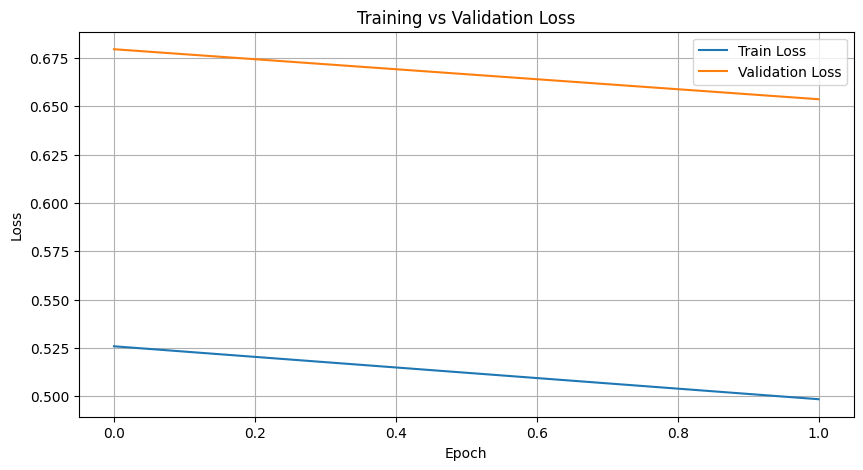

In [14]:
#Grafico 
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


RISULTATI FINALI:

mIoU (macro su tutte le classi): 0.0762
F1-score (macro su tutte le classi): 0.1208

 IoU per classe:
Classe 0: IoU = 0.8622
Classe 1: IoU = 0.5577
Classe 2: IoU = 0.0342
Classe 3: IoU = 0.3013
Classe 4: IoU = 0.3092
Classe 5: IoU = 0.1462
Classe 6: IoU = 0.0008
Classe 7: IoU = 0.1770
Classe 8: IoU = 0.0479
Classe 9: IoU = 0.0051
Classe 10: IoU = 0.0315
Classe 11: IoU = 0.0533
Classe 12: IoU = 0.3683
Classe 13: IoU = 0.0590
Classe 14: IoU = 0.0584
Classe 15: IoU = 0.0123
Classe 16: IoU = 0.1969
Classe 17: IoU = 0.0504
Classe 18: IoU = 0.0830
Classe 19: IoU = 0.0050
Classe 20: IoU = 0.0035
Classe 21: IoU = 0.0256
Classe 22: IoU = 0.0000
Classe 23: IoU = 0.0153
Classe 24: IoU = 0.0224
Classe 25: IoU = 0.0000
Classe 26: IoU = 0.0715
Classe 27: IoU = 0.0000
Classe 28: IoU = 0.0028
Classe 29: IoU = 0.0460
Classe 30: IoU = 0.0298
Classe 31: IoU = 0.0009
Classe 32: IoU = 0.0000
Classe 33: IoU = 0.0308
Classe 34: IoU = 0.0117
Classe 35: IoU = 0.0000
Classe 36: IoU = 0.0000


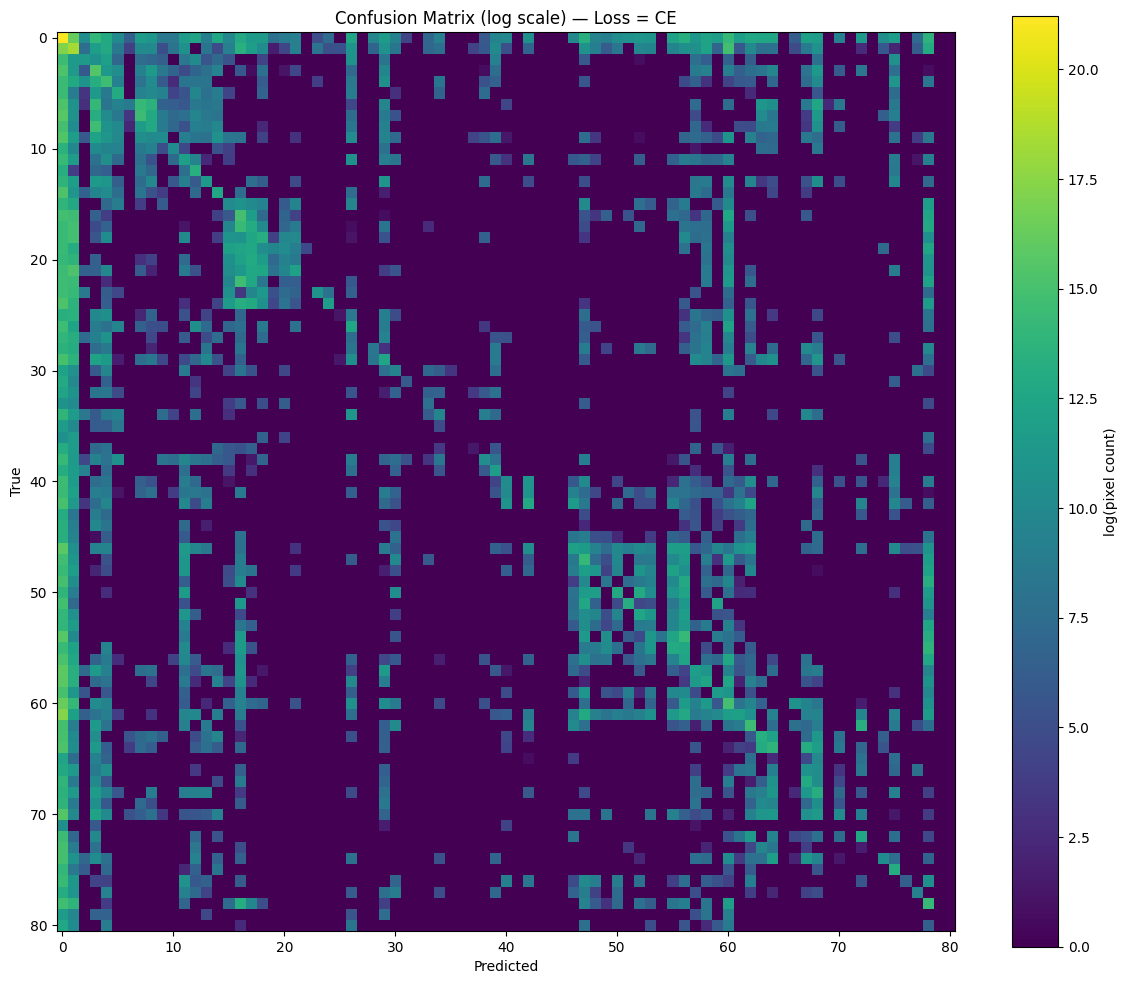

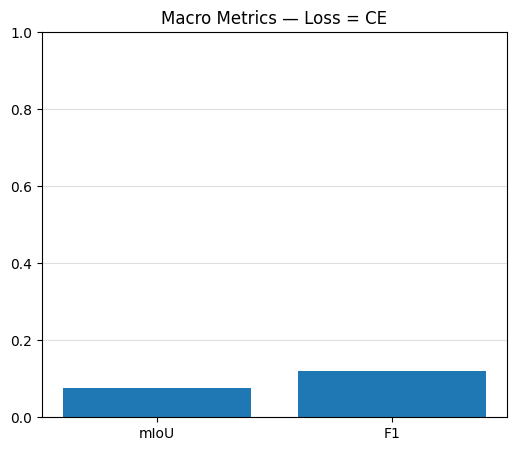

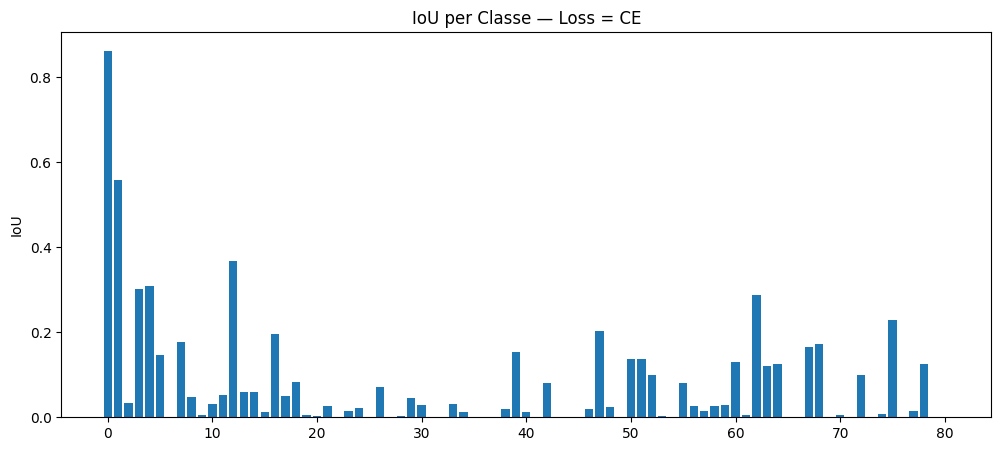

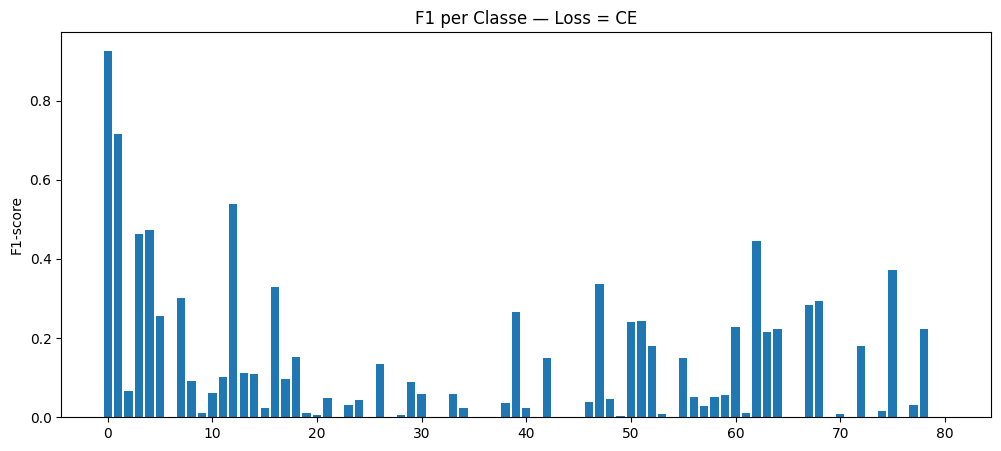

In [15]:
##############################################################
#  Valutazioni con metriche per Semantic Segmentation
#  IoU, F1 score, Confusion Matrix
##############################################################

#Inizializzazione

NUM_CLASSES = model.classifier[4].out_channels

TP  = np.zeros(NUM_CLASSES, dtype=np.float64)
FP  = np.zeros(NUM_CLASSES, dtype=np.float64)
FN  = np.zeros(NUM_CLASSES, dtype=np.float64)
TN  = np.zeros(NUM_CLASSES, dtype=np.float64)

conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

#Calcolo

model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        logits = model(imgs)["out"]   # predizione
        preds  = logits.argmax(dim=1)  
        preds_np = preds.cpu().numpy()
        gts_np   = masks.cpu().numpy()
        for p, g in zip(preds_np, gts_np):            # pixel-wise evaluation
            # Confusion matrix
            cm = np.bincount(
                g.flatten() * NUM_CLASSES + p.flatten(),
                minlength=NUM_CLASSES**2
            ).reshape(NUM_CLASSES, NUM_CLASSES)
            conf_matrix += cm
            for c in range(NUM_CLASSES):
                TP[c] += cm[c, c]
                FP[c] += cm[:, c].sum() - cm[c, c]
                FN[c] += cm[c, :].sum() - cm[c, c]
                TN[c] += cm.sum() - (TP[c] + FP[c] + FN[c])


IoU_perclass = TP / (TP + FP + FN + 1e-9)
mIoU = float(IoU_perclass.mean())
F1_perclass = (2 * TP) / (2 * TP + FP + FN + 1e-9)
F1_macro = float(F1_perclass.mean())

#Stampa
loss_name = LOSS_MODE
print("\nRISULTATI FINALI:\n")
print(f"mIoU (macro su tutte le classi): {mIoU:.4f}")
print(f"F1-score (macro su tutte le classi): {F1_macro:.4f}")

print("\n IoU per classe:")
for i in range(NUM_CLASSES):
    print(f"Classe {i}: IoU = {IoU_perclass[i]:.4f}")
print("\n F1 per classe:")
for i in range(NUM_CLASSES):
    print(f"Classe {i}: F1 = {F1_perclass[i]:.4f}")

#Stampa per Matrice Confusione
plt.figure(figsize=(12, 10))
plt.imshow(np.log1p(conf_matrix), cmap="viridis")
plt.colorbar(label="log(pixel count)")
plt.title(f"Confusion Matrix (log scale) — Loss = {loss_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(f"/kaggle/working/conf_matrix_{loss_name}.png", dpi=300)
plt.show()

#Istrogrammi IoU/F1
plt.figure(figsize=(6,5))
plt.bar(["mIoU", "F1"], [mIoU, F1_macro])
plt.ylim(0,1)
plt.grid(axis="y", alpha=0.4)
plt.title(f"Macro Metrics — Loss = {loss_name}")
plt.savefig(f"/kaggle/working/macro_metrics_{loss_name}.png", dpi=300)
plt.show()


plt.figure(figsize=(12,5))
plt.bar(np.arange(NUM_CLASSES), IoU_perclass)
plt.title(f"IoU per Classe — Loss = {loss_name}")
plt.ylabel("IoU")
plt.savefig(f"/kaggle/working/IoU_perclass_{loss_name}.png", dpi=300)
plt.show()


plt.figure(figsize=(12,5))
plt.bar(np.arange(NUM_CLASSES), F1_perclass)
plt.title(f"F1 per Classe — Loss = {loss_name}")
plt.ylabel("F1-score")
plt.savefig(f"/kaggle/working/F1_perclass_{loss_name}.png", dpi=300)
plt.show()


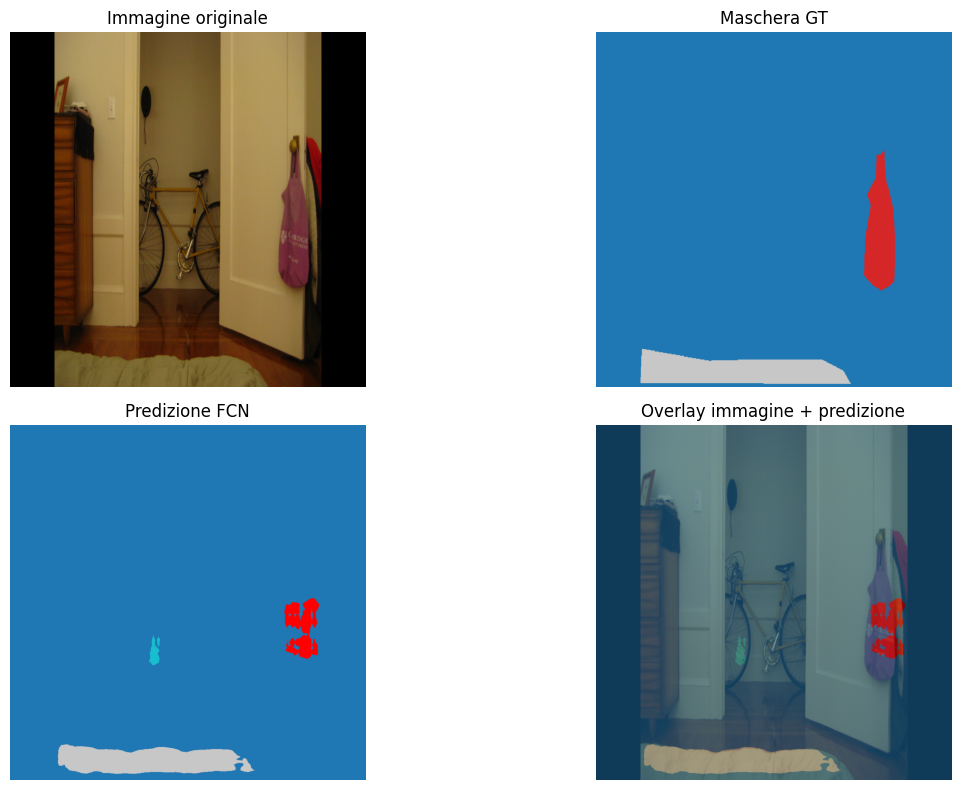

In [16]:
def visualize_sample(dataset, model, index=0, num_classes=NUM_CLASSES, person_class_index=1):
    
    model.eval()
    img, gt_mask = dataset[index]
    inp = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(inp)["out"].argmax(1).squeeze(0).cpu().numpy()

    img_np = img.permute(1, 2, 0).cpu().numpy() 
    gt_np = gt_mask.numpy()

    # Colormap
    cmap_base = plt.get_cmap("tab20")
    mask_color = (cmap_base(np.arange(num_classes) / max(num_classes-1, 1))[:, :3] * 255).astype(np.uint8)
    if person_class_index < num_classes:   #Contrasto rosso per la classe persona
        mask_color[person_class_index] = np.array([255, 0, 0], dtype=np.uint8)
    def mask_to_rgb(mask):
        h, w = mask.shape
        rgb = np.zeros((h, w, 3), dtype=np.uint8)
        for i in range(num_classes):
            rgb[mask == i] = mask_color[i]
        return rgb

    gt_rgb = mask_to_rgb(gt_np)
    pred_rgb = mask_to_rgb(pred)


    
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(gt_rgb)
    plt.title("Maschera GT")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(pred_rgb)
    plt.title("Predizione FCN")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(img_np)
    plt.imshow(pred_rgb, alpha=0.5)
    plt.title("Overlay immagine + predizione")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



index = random.randint(0, len(small_subset)-1)
visualize_sample(small_subset, model, index)
